In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

from itertools import product
from collections import OrderedDict, namedtuple
from easydl import clear_output
from IPython.display import display

import time
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=120)

[easydl] tensorflow not available!


In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.6.0+cu101
0.7.0+cu101


In [3]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # 灰度图像的channels=1即in_channels=1 输出为10个类别即out_features=10
        # parameter(形参)=argument(实参) 卷积核即卷积滤波器 out_channels=6即6个卷积核 输出6个feature-maps(特征映射)
        # 权重shape 6*1*5*5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)  # 二维批归一化 输入size=6
        # 权重shape 12*1*5*5
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        # 全连接层：fc or dense or linear out_features即特征(一阶张量)
        # 权重shape 120*192
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.bn2 = nn.BatchNorm1d(120)  # 一维批归一化 输入size=120
        # 权重shape 60*120
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        # 权重shape 10*60
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t = t
        # (2) hidden conv layer
        t = F.relu(self.conv1(t))  # (28-5+0)/1+1=24 输入为b(batch_size)*1*28*28 输出为b*6*24*24 relu后shape不变
        t = F.max_pool2d(t, kernel_size=2, stride=2)  # (24-2+0)/2+1=12 输出为b*6*12*12
        t = self.bn1(t)
        
        # (3) hidden conv layer
        t = F.relu(self.conv2(t))  # (12-5+0)/1+1=8 输出为b*12*8*8 relu后shape不变
        t = F.max_pool2d(t, kernel_size=2, stride=2)  # (8-2+0)/2+1=4 输出为b*12*4*4
        
        # (4) hidden linear layer
        t = F.relu(self.fc1(t.reshape(-1, 12*4*4)))  # t.reshape后为b*192 全连接层后输出为b*120 relu后shape不变
        t = self.bn2(t)
        # (5) hidden linear layer
        t = F.relu(self.fc2(t))  # 全连接层后输出为b*60 relu后shape不变
        
        # (6) output layer
        t = self.out(t)  # 全连接层后输出为b*10 relu后shape不变
        return t

In [9]:
class RunBuilder:
    @staticmethod
    def get_run(params):  # 静态方法，不需要实例化

        Run = namedtuple('Run', params.keys())
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

60000
tensor(0.2861) tensor(0.3530)
60000
tensor(-0.0001) tensor(1.)


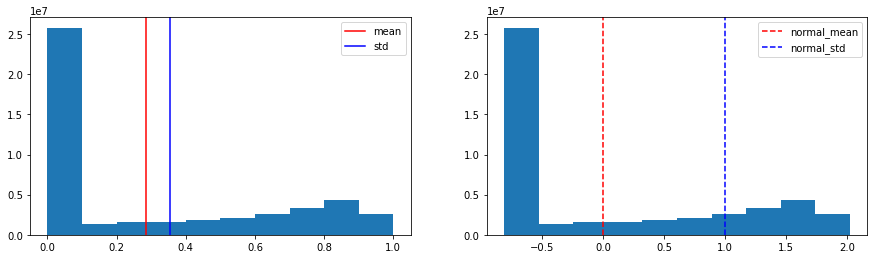

In [4]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=True,
    download=True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)
print(len(train_set))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), num_workers=1)
train_data = next(iter(train_loader))
train_mean, train_std = train_data[0].mean(), train_data[0].std()
print(train_mean, train_std)

train_set_normal = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=True,
    download=True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)  # RGB图片则为transforms.Normalize([mean1, mean2, mean3], [std1, std2, std3])
    ])
)
print(len(train_set_normal))
train_loader = torch.utils.data.DataLoader(train_set_normal, batch_size=len(train_set), num_workers=1)
train_data_normal = next(iter(train_loader))
train_mean_normal, train_std_normal = train_data_normal[0].mean(), train_data_normal[0].std()
print(train_mean_normal, train_std_normal)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.hist(train_data[0].flatten())
plt.axvline(train_data[0].mean(), c='r')
plt.axvline(train_data[0].std(), c='b')
plt.legend(['mean', 'std'])
plt.subplot(122)
plt.hist(train_data_normal[0].flatten())
plt.axvline(train_data_normal[0].mean(), c='r', ls='--')
plt.axvline(train_data_normal[0].std(), c='b', ls='--')
plt.legend(['normal_mean', 'normal_std'])

10000
tensor(0.2868) tensor(0.3524)
10000
tensor(5.4658e-06) tensor(1.)


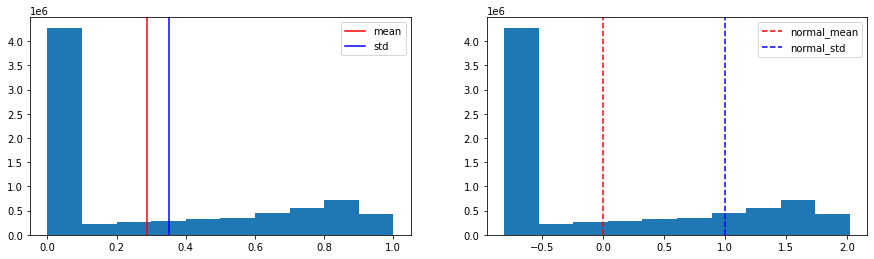

In [5]:
test_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=False,
    download=True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)
print(len(test_set))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), num_workers=1)
test_data = next(iter(test_loader))
test_mean, test_std = test_data[0].mean(), test_data[0].std()
print(test_mean, test_std)

test_set_normal = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=False,
    download=True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(test_mean, test_std)  # RGB图片则为transforms.Normalize([mean1, mean2, mean3], [std1, std2, std3])
    ])
)
print(len(test_set_normal))
test_loader = torch.utils.data.DataLoader(test_set_normal, batch_size=len(test_set_normal), num_workers=1)
test_data_normal = next(iter(test_loader))
test_mean_normal, test_std_normal = test_data_normal[0].mean(), test_data_normal[0].std()
print(test_mean_normal, test_std_normal)
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.hist(test_data[0].flatten())
plt.axvline(test_data[0].mean(), c='r')
plt.axvline(test_data[0].std(), c='b')
plt.legend(['mean', 'std'])
plt.subplot(122)
plt.hist(test_data_normal[0].flatten())
plt.axvline(test_data_normal[0].mean(), c='r', ls='--')
plt.axvline(test_data_normal[0].std(), c='b', ls='--')
plt.legend(['normal_mean', 'normal_std'])

In [6]:
import pandas as pd
import numpy as np
import os
import json
import datetime

def save_result(model, run_data):
    """
    运行结果保存
        默认文件路径 ./run_data
        默认模型路径 ./model
    :param model: 模型
    :param run_data: 运行数据
    """
    result_dir = './run_data'
    model_dir = './model'
    name = 'result'
    
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
        
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    time_index = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # 保存运行文件
    run_data_path = os.path.join(result_dir, name)
    pd.DataFrame(run_data).to_csv(f'{run_data_path}_{time_index}.csv', index=False)
    with open(f'{run_data_path}_{time_index}.json', 'w', encoding='utf-8') as f:
        json.dump(run_data, f, ensure_ascii=False, indent=4)
    
    # 保存运行模型
    model_path = os.path.join(model_dir, name)
    torch.save(model.state_dict(), f'{model_path}_{time_index}.pt')

In [7]:
train_set_dict = {
    'normal': train_set_normal,
    'no_normal': train_set
}

train_params = OrderedDict(
    lr = [.01, .001],
    batch_size = [1000, 2000],
    shuffle = [True, False],
    device = ['cuda'],
    num_workers = [1],  # 有多少子进程被用来加载数据 默认为0即在主进程中加载数据 可以利用多核CPU的特点指定num_workers个数 提前将数据加载到内存中
    normalize = list(train_set_dict.keys())
)

test_params = OrderedDict(
    lr = [np.nan],
    batch_size = [1000],
    shuffle = [True],
    device = ['cuda'],
    num_workers = [1],  # 有多少子进程被用来加载数据 默认为0即在主进程中加载数据 可以利用多核CPU的特点指定num_workers个数 提前将数据加载到内存中
    normalize = ['normal']
)

In [8]:
run_count = 0
run_data = []

model = None
hightest_accuracy = 0

test_run = next(iter(RunBuilder.get_run(test_params)))

for run in RunBuilder.get_run(train_params):
    
    device = torch.device(run.device)
    network = Network().to(device)
    train_loader = torch.utils.data.DataLoader(train_set_dict[run.normalize], batch_size=run.batch_size, num_workers=run.num_workers, shuffle=run.shuffle)
    test_loader = torch.utils.data.DataLoader(test_set_normal, batch_size=test_run.batch_size, num_workers=test_run.num_workers, shuffle=test_run.shuffle)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)
    
    run_start_time = time.time()
    run_count += 1
    epoch_count = 0
    test_epoch_count = 0
    tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images)

    tb.add_image('images', grid)
    tb.add_graph(network, images.to(getattr(run, 'device', 'run')))  # run中的device属性存在则使用,不存在则使用默认属性cpu
    for epoch in range(20):
        
        epoch_start_time = time.time()
        epoch_count += 1
        epoch_loss = 0
        epoch_correct_num = 0
        for batch in train_loader:
            
            images = batch[0].to(device)
            labels = batch[1].to(device)
            preds = network(images)                # 前向传播 根据权重参数进行预测 
            loss = F.cross_entropy(preds, labels)  # 计算损失 构建计算图

            optimizer.zero_grad()                  # pytorch会积累梯度 在优化每个batch的权重的梯度之前将之前权重的梯度置为0
            loss.backward()                        # 在最后一个张量上调用反向传播方法 在计算图中计算权重梯度
            optimizer.step()                       # 使用预先设置的learning_rate的梯度来更新权重参数
            
            epoch_loss += loss.item() * train_loader.batch_size
            epoch_correct_num += preds.argmax(dim=1).eq(labels).sum().item()
            
        epoch_duration = time.time() - epoch_start_time
        run_duration = time.time() - run_start_time

        loss = epoch_loss / len(train_loader.dataset)  # len(loader.dataset) = 60000
        accuracy = epoch_correct_num / len(train_loader.dataset)

        tb.add_scalar('Train Loss', loss, epoch_count)
        tb.add_scalar('Train Accuracy', accuracy, epoch_count)

        for name, param in network.named_parameters():
            tb.add_histogram(name, param, epoch_count)
            tb.add_histogram(f'{name}.grad', param.grad, epoch_count)

        results = OrderedDict()
        results['current'] = 'Train' 
        results['run'] = run_count
        results['epoch'] = epoch_count
        results['loss'] = loss
        results['accuracy'] = accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        for k, v in run._asdict().items():
            results[k] = v
        run_data.append(results)
        
        clear_output()
        display(pd.DataFrame(run_data))
        #  对测试集进行预测
        if epoch_count % 5 == 0:
            test_epoch_start_time = time.time()
            test_epoch_count += 1
            test_epoch_loss = 0
            test_epoch_correct_num = 0

            for batch in test_loader:

                images = batch[0].to(device)
                labels = batch[1].to(device)
                preds = network(images)                # 前向传播 根据权重参数进行预测 
                test_loss = F.cross_entropy(preds, labels)  # 计算损失 构建计算图

                test_epoch_loss += test_loss.item() * test_loader.batch_size
                test_epoch_correct_num += preds.argmax(dim=1).eq(labels).sum().item()

            test_epoch_duration = time.time() - test_epoch_start_time
            test_run_duration = time.time() - run_start_time

            test_loss = test_epoch_loss / len(test_loader.dataset)  # len(loader.dataset) = 10000
            test_accuracy = test_epoch_correct_num / len(test_loader.dataset)

            tb.add_scalar('Test Loss', test_loss, test_epoch_count)
            tb.add_scalar('Test Accuracy', test_accuracy, test_epoch_count)

            results = OrderedDict()
            results['current'] = 'Test' 
            results['run'] = run_count
            results['epoch'] = test_epoch_count
            results['loss'] = test_loss
            results['accuracy'] = test_accuracy
            results['epoch duration'] = test_epoch_duration
            results['run duration'] = test_run_duration
            for k, v in test_run._asdict().items():
                results[k] = v
            run_data.append(results)

            clear_output()
            display(pd.DataFrame(run_data))
        
    if test_accuracy > hightest_accuracy:
        hightest_accuracy = test_accuracy
        model = network
    tb.close()
save_result(model, run_data)
print('测试集最高准确率: %s'% hightest_accuracy)
print(model)

,current,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,shuffle,device,num_workers,normalize
0,Train,1,1,0.576130,0.790067,9.174030,12.679071,0.010,1000,True,cuda,1,normal
1,Train,1,2,0.338247,0.874850,9.187044,22.336514,0.010,1000,True,cuda,1,normal
2,Train,1,3,0.293255,0.891433,8.751546,31.617636,0.010,1000,True,cuda,1,normal
3,Train,1,4,0.277946,0.895267,8.884610,40.909518,0.010,1000,True,cuda,1,normal
4,Train,1,5,0.262462,0.901850,10.534001,51.826787,0.010,1000,True,cuda,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,Train,16,17,0.220133,0.918483,4.520554,88.146803,0.001,2000,False,cuda,1,no_normal
380,Train,16,18,0.216622,0.920183,4.559624,93.013441,0.001,2000,False,cuda,1,no_normal
381,Train,16,19,0.211505,0.922500,4.573331,97.765098,0.001,2000,False,cuda,1,no_normal
382,Train,16,20,0.206646,0.924650,4.590543,102.555541,0.001,2000,False,cuda,1,no_normal


测试集最高准确率: 0.8981
Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (bn2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)
